In [1]:
import pandas as pd
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from attention import AttentionLayer
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [85]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Aditya
[nltk_data]     Parihar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [80]:
df = pd.read_csv(r"C:\Users\Aditya Parihar\Downloads\news_summary_more.csv\news_summary_more.csv", encoding='ISO-8859-1', nrows=15000)

In [81]:
df

,headlines,text
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ..."
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi..."
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c..."
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam","Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""I..."
...,...,...
14995,"Fire breaks out at Kolkata hospital, over 200 patients evacuated",A fire broke out in the pharmacy department of Kolkata Medical College and Hospital on Wednesday morning. More than 200 patients were evacuated and reported to be safe. About 10 fire engines and K...
14996,"UP policeman shot at me to earn promotion, claims ex-bodybuilder","Jitender Yadav, a 26-year-old ex-bodybuilder, revealed a drunk UP sub-inspector shot him to earn promotion in February. Yadav said he was standing with his friends outdoors after his sister's marr..."
14997,Video of airport baggage handlers throwing luggage goes viral,"A video of baggage handlers throwing suitcases and fragile boxes off a conveyor belt at Hong Kong airport has gone viral. ""This is the way that our beloved luggage is treated,"" the passenger who r..."
14998,Canada strips Aung San Suu Kyi of honorary citizenship,Canada on Tuesday stripped Myanmar leader Aung San Suu Kyi of her honorary citizenship in response to crimes committed against the Rohingya minority. Suu Kyi is the first person to have her honora...


In [82]:
df.columns = ['summary' , 'Text']

In [83]:
df.head()

,summary,Text
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ..."
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi..."
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c..."
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam","Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""I..."


In [84]:
data = df


In [86]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [88]:
stop_words = set(stopwords.words('english')) 

def cleaning_text(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [89]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(cleaning_text(t,0))
cleaned_summary = []
for t in data['summary']:
    cleaned_summary.append(cleaning_text(t,1))
    
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

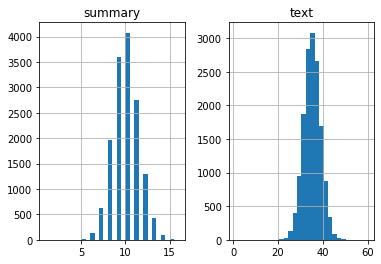

In [93]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

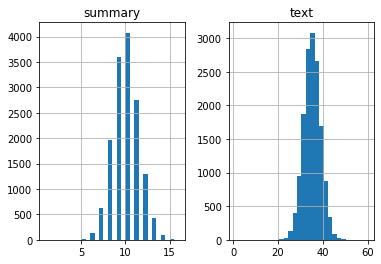

In [94]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [95]:
max_text_len=40
max_summary_len=11

In [96]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=11):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.8771333333333333


In [97]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [98]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [99]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.05,random_state=101,shuffle=True)

In [100]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [101]:
thresh=3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 53.453861427526384
Total Coverage of rare words: 5.017614328515458


In [102]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [103]:
x_voc

13363

In [104]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [105]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 77.46291786584017
Total Coverage of rare words: 14.76746596641559


In [106]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [107]:

y_tokenizer.word_counts['sostok'],len(y_tr)

(11372, 11372)

In [108]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [109]:

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [110]:
from tensorflow.keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1_f = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_lstm1_r = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4,go_backwards=True)## ##

encoder_bi1 = Bidirectional(encoder_lstm1_f, backward_layer=encoder_lstm1_r)
encoder_output1, state_h1, state_c1, state_r_h1, state_r_h1 = encoder_bi1(enc_emb)

#encoder lstm 2
encoder_lstm2_r = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4,go_backwards=True)##
encoder_lstm2_f = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)

encoder_bi2 = Bidirectional(encoder_lstm2_f, backward_layer=encoder_lstm2_r)
encoder_output2, state_h2, state_c2, state_r_h2, state_r_h2 = encoder_bi2(encoder_output1)

#encoder lstm 3
encoder_lstm3_f= LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_lstm3_r= LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4,go_backwards=True)##
encoder_bi3 = Bidirectional(encoder_lstm2_f, backward_layer=encoder_lstm2_r, merge_mode="sum")
encoder_outputs, state_h, state_c, state_r_h, state_r_h = encoder_bi3(encoder_output2)
print(encoder_outputs.shape)
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

(None, 40, 300)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 100)      1336300     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 40, 600), (N 962400      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________

In [111]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [112]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [113]:
x_tr.shape

(11370, 40)

In [114]:

history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=107, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
107/107 [==============================] - 4205s 39s/step - loss: 5.7255 - val_loss: 5.3700
Epoch 2/50
107/107 [==============================] - 3959s 37s/step - loss: 5.3623 - val_loss: 5.2215
Epoch 3/50
107/107 [==============================] - 4656s 44s/step - loss: 5.2445 - val_loss: 5.1541
Epoch 4/50
107/107 [==============================] - 4344s 41s/step - loss: 5.1049 - val_loss: 5.0178
Epoch 5/50
107/107 [==============================] - 10022s 94s/step - loss: 4.9619 - val_loss: 4.9475
Epoch 6/50
107/107 [==============================] - 3524s 33s/step - loss: 4.8395 - val_loss: 4.8801
Epoch 7/50
107/107 [==============================] - 5926s 55s/step - loss: 4.7210 - val_loss: 4.8264
Epoch 8/50
107/107 [==============================] - 46436s 434s/step - loss: 4.6139 - val_loss: 4.7454
Epoch 9/50
107/107 [==============================] - 3749s 35s/step - loss: 4.5120 - val_loss: 4.7255
Epoch 10/50
107/107 [==============================] - 3494s 33s/step 

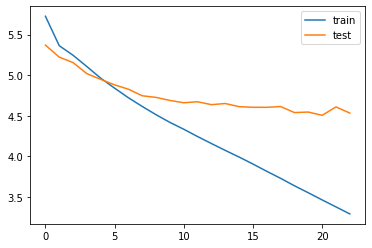

In [115]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [116]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [117]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [118]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [119]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [120]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: horlicks recently india first kind talent mentorship workshop passion help kids discover encourage also released video features young children constantly pushing limits challenging different fields 
Original summary: with kids to do more 
Predicted summary:  to be with in india


Review: railway minister piyush goyal wednesday announced lakh additional vacancies filled next two years new quota economically weaker sections general category applicable vacancies recruitment drive carried two phases 
Original summary: railways announces lakh quota 
Predicted summary:  cabinet approves cr worth lakh


Review: research team mit nasa developed drone technology used search rescue people dense forests without using gps using onboard wireless communication drones create individual map terrain technology enables drones recognise explored territories within forests 
Original summary: drones that can search people lost in without made 
Predicted summary:  scientists find to be made


Review

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x000002878DABEE18>
Traceback (most recent call last):
  File "C:\Users\Aditya Parihar\Anaconda3\lib\site-packages\tensorflow\python\eager\function.py", line 386, in __del__
    context.remove_function(self.name)
  File "C:\Users\Aditya Parihar\Anaconda3\lib\site-packages\tensorflow\python\eager\context.py", line 2353, in remove_function
    context().remove_function(name)
KeyboardInterrupt: 
Exception ignored in: <function ScopedTFFunction.__del__ at 0x000002878BF74D90>
Traceback (most recent call last):
  File "C:\Users\Aditya Parihar\Anaconda3\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 96, in __del__
    self.deleter(self.func)
KeyboardInterrupt: 


Predicted summary:  reliance industries profit rises to crore in september quarter


Review: us asked pakistan legislation formally bans mumbai attack mastermind hafiz saeed led jamaat ud foundation two longer banned ordinance banned lapsed pakistani government extend removal ban runs counter pakistan commitment fight terrorism us said 
Original summary: us asks pakistan to ban 
Predicted summary:  pakistan to give afghanistan nuclear nuclear nations


Review: actress filed lawsuit accusing hollywood producer harvey weinstein sexual harassment alleged rejected advances producer bragged sleeping hollywood actress jennifer lawrence lawsuit actress accused weinstein forcing oral sex woman claimed weinstein repeatedly masturbated front 
Original summary: about sleeping with actress 
Predicted summary:  aamir to star in film film film report


Review: least three workers killed sunday run mumbai bound express maharashtra raigad district police said workers working track near railway station

In [121]:
summ = 'Cricket is a bat-and-ball game played between two teams of eleven players on a field at the centre of which is a 22-yard (20-metre) pitch with a wicket at each end, each comprising two bails balanced on three stumps. The batting side scores runs by striking the ball bowled at the wicket with the bat (and running between the wickets), while the bowling and fielding side tries to prevent this (by preventing the ball from leaving the field, and getting the ball to either wicket) and dismiss each batter (so they are "out"). Means of dismissal include being bowled, when the ball hits the stumps and dislodges the bails, and by the fielding side either catching the ball after it is hit by the bat, but before it hits the ground, or hitting a wicket with the ball before a batter can cross the crease in front of the wicket. When ten batters have been dismissed, the innings ends and the teams swap roles. The game is adjudicated by two umpires, aided by a third umpire and match referee in international matches. They communicate with two off-field scorers who record the match'
cleaned =np.array([ cleaning_text(summ ,0)])
summ_seq = x_tokenizer.texts_to_sequences(cleaned)
summ_seq = pad_sequences(summ_seq , maxlen=max_text_len , padding='post')
pred = decode_sequence(summ_seq.reshape(1,max_text_len))

In [122]:
print(pred)

 scores in india after cricket win
